### Experiment 3
* Replace those special characters

In [1]:
import copy
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import sys
import os
import re
import threading
import multiprocessing

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import lightgbm as lgb
from sklearn import metrics
import gc

# from __future__ import print_function
np.random.seed(786)  # for reproducibility

from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import *
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier,  KerasRegressor
#Some classes
#Functions we need - Feature Selector, Fasttext_Estimator, Preprocessing Transformer, Binary_Encoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from pandas.api.types import is_numeric_dtype, is_string_dtype
from scipy.sparse.csr import csr_matrix
from sklearn.metrics import mean_squared_error, make_scorer

def rmse(y_true, y_pred):
    print(np.min(y_pred), np.max(y_pred))
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_sklearn = make_scorer(rmse, greater_is_better=False)

def get_obj_cols(df):
    """Return columns with object dtypes"""
    obj_cols = []
    for idx, dt in enumerate(df.dtypes):
        if dt == 'object':
            obj_cols.append(df.columns.values[idx])

    return obj_cols


def convert_input(X):
    """if input not a dataframe convert it to one"""
    if not isinstance(X, pd.DataFrame):
        if isinstance(X, list):
            X = pd.DataFrame(np.array(X))
        elif isinstance(X, (np.generic, np.ndarray)):
            X = pd.DataFrame(X)
        elif isinstance(X, csr_matrix):
            X = pd.SparseDataFrame(X)
        else:
            raise ValueError('Unexpected input type: %s' % (str(type(X))))

        #X = X.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    return X

class FeatureSelector(BaseEstimator, TransformerMixin):
    """ Class to do subset of features in sklearn pipeline"""
    def __init__(self, cols=None, return_df=True, verbose=0):
        self.cols = cols
        self.return_df = return_df
        self.verbose = verbose
        
    def fit(self, X, y=None):
        #Do nothing
        return self
    
    def transform(self, X, y=None):
        #if the input dataset isn't already a dataframe, convert it to one
        X = X.copy(deep=True)
        X = convert_input(X)
        X = X.loc[:, self.col]
        
        if self.verbose:
            print("Selecting columns are {}".format(self.col))
        if self.return_df:
            return X
        else:
            return X.values

        



class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, thresh=0, func=np.mean, add_to_orig=False):
        self.cols = cols
        self.thresh = thresh
        self.func = func
        self.add_to_orig = add_to_orig
    
    #@numba.jit        
    def fit(self, X, y):
        self.prior = self.func(y)
        self._dict = {}
        for col in self.cols:
            if isinstance(col, (list, tuple)):
                print('here')
                tmp_df = X.loc[: ,col]
                col = tuple(col)
            else:
                tmp_df = X.loc[: ,[col]]
            tmp_df['y'] = y
            print(tmp_df.columns)
            #tmp_df = pd.DataFrame({'eval_col':X[col].values, 'y':y})
            if isinstance(col, (list, tuple)):
                print('here')
                col = tuple(col)
            self._dict[col] = tmp_df.groupby(col)['y'].apply(lambda x: 
                                self.func(x) if len(x) >= self.thresh  else self.prior).to_dict()
                                
            del tmp_df
        return self
    #@numba.jit
    def transform(self, X, y=None):
        X_transformed = []
        for col in self.cols:
            
            if isinstance(col, (list, tuple)):
                tmp_df = X.loc[:, col]
                enc = tmp_df[col].apply(lambda x: self._dict[tuple(col)][tuple(x)]
                                                                     if tuple(x) in self._dict[tuple(col)]
                                                                     else self.prior, axis=1).values
            else:
                tmp_df = X.loc[:, [col]]
                enc = tmp_df[col].apply(lambda x: self._dict[col][x]
                                                                     if x in self._dict[col]
                                                                     else self.prior).values
            del tmp_df
            X_transformed.append(enc)
        
        X_transformed = np.vstack(X_transformed).T
        
        if self.add_to_orig:
            return np.concatenate((X.values, X_transformed), axis=1)
            
        else:
            return X_transformed
        
def isiphonecase(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                                (series.str.contains('case', flags=re.IGNORECASE)) )
def isiphone6(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('6|six', flags=re.IGNORECASE) &
                        ~(series.str.contains('plus|\+', flags=re.IGNORECASE)) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone6p(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('6|six', flags=re.IGNORECASE) &
                        series.str.contains('plus|\+', flags=re.IGNORECASE) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone5(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('5|five', flags=re.IGNORECASE) &
                        ~(series.str.contains('plus|\+', flags=re.IGNORECASE)) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone5p(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('5|five', flags=re.IGNORECASE) &
                        series.str.contains('plus|\+', flags=re.IGNORECASE) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone7(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('7|seven', flags=re.IGNORECASE) &
                        ~(series.str.contains('plus|\+', flags=re.IGNORECASE)) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

def isiphone7p(series): return (series.str.contains('iphone', flags=re.IGNORECASE) & 
                        series.str.contains('7|seven', flags=re.IGNORECASE) &
                        series.str.contains('plus|\+', flags=re.IGNORECASE) &
                                ~(series.str.contains('case', flags=re.IGNORECASE)) )

#Data reading function
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.)

        
def tokenize(text):
    return text.lower().strip(string.punctuation).split()


def read_data(in_path, out_path):
    if False and os.path.exists(os.path.join(out_path, 'train_2.pkl')) and os.path.exists(os.path.join(out_path, 'test_2.pkl')):
        train_data = pd.read_pickle(os.path.join(out_path, 'train_2.pkl'))
        test_data  = pd.read_pickle(os.path.join(out_path, 'test_2.pkl'))
        
        return train_data, test_data
    
    else:
        train_data = pd.read_table(os.path.join(in_path, 'train.tsv'))
        test_data  = pd.read_table(os.path.join(in_path, 'test.tsv'))
    
        train_rows = len(train_data)
        data = pd.concat([train_data, test_data], ignore_index=True)
    
        data['cat1'] = data['category_name'].apply(lambda x: str(x).split('/')[0])
        data['cat2'] = data['category_name'].apply(lambda x: str(x).split('/')[1] 
                                                   if len(str(x).split('/')) > 1 else -1)
        data['cat3'] = data['category_name'].apply(lambda x: ' '.join(str(x).split('/')[2:]) 
                                                   if len(str(x).split('/')) > 2 else -1)
        data.fillna(-1, inplace=True)
        
        print("Getting word/char len features")
        data['desc_words'] = data['item_description'].apply(lambda x: len(str(x).split()))
        data['desc_chars'] = data['item_description'].apply(lambda x: len(str(x)))
        data['name_words'] = data['name'].apply(lambda x: len(str(x).split()))
        data['name_chars'] = data['name'].apply(len)
        
        
        print("Get iphone features")
        data['iphone_case'] = isiphonecase(data['name'])
        data['iphone6'] = isiphone6(data['name'])
        data['iphone6p'] = isiphone6p(data['name'])
        data['iphone5'] = isiphone5(data['name'])
        data['iphone5p'] = isiphone5p(data['name'])
        data['iphone7'] = isiphone7(data['name'])
        data['iphone7p'] = isiphone7p(data['name'])
        data['unlocked_phone'] = data.name.str.contains('unlocked', flags=re.IGNORECASE)
        cat_cols = ['category_name', 'brand_name', 'cat1', 'cat2', 'cat3', 'item_condition_id']
        for col in cat_cols:
            data[col] = LabelEncoder().fit_transform(data[col].astype(str)) + 1
            
        print("Get count features")
        target_enc1 = TargetEncoder(cols=['brand_name'], func=len)
        data['brand_counts'] = target_enc1.fit_transform(data[['brand_name']], data.price)
        data['brand_counts'] = data['brand_counts']/data['brand_counts'].max()

        target_enc2 = TargetEncoder(cols=['category_name'], func=len)
        data['cat_counts'] = target_enc2.fit_transform(data[['category_name']], data.price)
        data['cat_counts'] = data['cat_counts']/data['cat_counts'].max()
        
        target_enc3 = TargetEncoder(cols=['cat1'], func=len)
        data['cat1_counts'] = target_enc3.fit_transform(data[['cat1']], data.price)
        data['cat1_counts'] = data['cat1_counts']/data['cat1_counts'].max()
        
        target_enc4 = TargetEncoder(cols=['cat2'], func=len)
        data['cat2_counts'] = target_enc4.fit_transform(data[['cat2']], data.price)
        data['cat2_counts'] = data['cat2_counts']/data['cat2_counts'].max()
        
        target_enc5 = TargetEncoder(cols=['cat3'], func=len)
        data['cat3_counts'] = target_enc5.fit_transform(data[['cat3']], data.price)
        data['cat3_counts'] = data['cat3_counts']/data['cat3_counts'].max()
        #tkn_desc = Tokenizer(50000)   
        
        #reg = re.compile('[^a-zA-Z0-9 ]')
        data["plus_counts"] = data["name"].apply(lambda x: sum([(s == '+') | (s == '➕') for s in str(x)]))
        data["ands_counts"] = data["name"].apply(lambda x: sum([(s == '&') | (s == ' and ') for s in str(x)]))
        data["comma_counts"] = data["name"].apply(lambda x: sum([s == ',' for s in str(x)]))
        for col in ["name", "item_description"]:
            data[col] = data[col].str.replace("'", '').replace('-', '').replace('\+', ' ').replace('✨', ' ').replace('❤', ' ').replace('⚡', ' ')
        
        
        for col in ["desc_words", "desc_chars", "name_words", "name_chars", "plus_counts", "ands_counts", "comma_counts"]:
            data[col]  = data[col]/ data[col].max()
            
            
        data['item_desc2gram'] = data.item_description.apply(lambda x: add_ngrams(x, 2))
        print("Tokenizing data")
        tok_name  = Tokenizer(20000)
        tok_name.fit_on_texts(data['name'].astype(str))
        print(len(tok_name.word_index))
        
        tok_desc= Tokenizer(50000)
        tok_desc.fit_on_texts(data['item_description'].astype(str))
        print(len(tok_desc.word_index))
        
        tok_desc2 = Tokenizer(20000)
        tok_desc2.fit_on_texts(data['item_desc2gram'].astype(str))
        print(len(tok_desc2.word_index))
        
        data["name"] = list(zip(sequence.pad_sequences(tok_name.texts_to_sequences(data.name.astype(str)),
                                         maxlen=7, padding='post', truncating='post')))
        
        data["item_description"] = list(zip(sequence.pad_sequences(tok_desc.texts_to_sequences(data.item_description.astype(str)),
                                         maxlen=70, padding='post', truncating='post')))
        
        data["item_desc2gram"] = list(zip(sequence.pad_sequences(tok_desc2.texts_to_sequences(data.item_desc2gram.astype(str)),
                                         maxlen=30, padding='post', truncating='post')))
        #tkn_desc = Tokenizer(50000)
        #tkn_desc.fit_on_texts(data.item_description.astype(str))
        #data['desc_seq'] = pad_sequences(tkn_desc.texts_to_sequences(data.item_description.astype(str)),
        #                                 maxlen=100, padding='post', truncating='post')
        
        #tkn_name = Tokenizer(4000)
        #tkn_name.fit_on_texts(data.name.astype(str))
        #data['name_seq'] = pad_sequences(tkn_name.texts_to_sequences(data.name.astype(str)),
        #                                 maxlen=6, padding='post', truncating='post')
        
        
        train_data = data.loc[: train_rows - 1, :].reset_index(drop=True)
        train_data = train_data.loc[(train_data.price >= 1) & (train_data.price <= 2000), :].reset_index(drop=True)
        test_data  = data.loc[train_rows: , :].reset_index(drop=True)
        
        del train_data['test_id']
        del test_data['train_id']
        del data 
        test_data['test_id'] = test_data['test_id'].astype(int)
        #train_data.to_pickle(os.path.join(out_path, 'train_2.pkl'))
        #test_data.to_pickle(os.path.join(out_path, 'test_2.pkl'))
        
        return train_data, test_data
        


/home/mohsin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class EM_NNRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, embed_cols=None, dense_cols=None, embed_dims=None, 
                 text_embed_cols=None, text_embed_seq_lens=None, 
                 text_embed_dims=None, 
                 #text_embed_tokenizers=None,
                 num_layers=2, multiprocess=False,
                layer_activations=None, layer_dims=None,layer_dropouts=None, epochs=20, batchsize=32,
                optimizer_kwargs=None, val_size=0.1, verbose=1, seed=1,):
        
        self.embed_cols = embed_cols
        self.dense_cols = dense_cols
        self.embed_dims = embed_dims
        self.text_embed_cols = text_embed_cols
        self.text_embed_dims = text_embed_dims
        #self.text_embed_tokenizers = text_embed_tokenizers
        self.text_embed_seq_lens = text_embed_seq_lens
        self.dense_dims = None
        self.num_layers = num_layers
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.layer_dropouts = layer_dropouts
        self.epochs = epochs
        self.batchsize = batchsize
        self.optimizer_kwargs = optimizer_kwargs
        self.val_size = val_size
        self.verbose = verbose
        self.multiprocess = multiprocess
        self.seed = seed
        #self.optim = optim
        self.model = None
        if self.dense_cols:
            self.dense_dims = len(self.dense_cols)
            
    def _splitX(self, X):
        X_splits = []
        
        if self.embed_cols:
            for col in self.embed_cols :
                X_splits.append(X[col].values.reshape(X.shape[0], -1))
                
        if self.text_embed_cols:
            for i, col in enumerate(self.text_embed_cols):
                #max_features = self.text_embed_dims[i][0]
                #max_len = self.text_embed_seq_lens[i]
                #input_text = X[col].astype(str)
                #x_train = tok.texts_to_sequences(input_text)
                #print(np.mean([len(l) for l in x_train]))
                #x_train = sequence.pad_sequences(x_train, maxlen=max_len)
                #X_splits.append(np.array(x_train).reshape(X.shape[0], -1))
                X_splits.append(np.concatenate(X[col].values))
                
        if self.dense_cols:
            X_splits.append(X[self.dense_cols].values.reshape(X.shape[0], -1))
            
        return X_splits
    
    
    def _build_model(self):
        model_inputs = []
        model_layers = []
        
        if self.embed_cols:
            for col, dim in zip(self.embed_cols, self.embed_dims):
                x1 = Input( shape=(1,), name=col)
                model_inputs.append(x1)
                x1 = Embedding(input_dim=dim[0], output_dim=dim[1], )(x1)
                #x1 = Dropout(0.1)(x1)
                x1 = Reshape(target_shape=(dim[1],))(x1)
                model_layers.append(x1)
                
        if self.text_embed_cols:
            for col, dim, seq_len in zip(self.text_embed_cols, 
                                                self.text_embed_dims, 
                                                self.text_embed_seq_lens):
                x3 = Input( shape=(seq_len,))
                model_inputs.append(x3)
                x3 = Embedding(input_dim=dim[0], output_dim=dim[1], input_length=seq_len)(x3)
                x3 = GlobalAveragePooling1D()(x3)
                x3 = Reshape(target_shape=(dim[1],))(x3)
                model_layers.append(x3)
                
        if self.dense_cols:
            x2 = Input( shape=(self.dense_dims, ), name='dense_cols')
            model_inputs.append(x2)
            model_layers.append(x2)
        print(model_layers)
        x = concatenate(model_layers)
        
        if self.num_layers > 0:
            for dim, drops in zip(self.layer_dims, self.layer_dropouts):
                x = BatchNormalization()(x)
                x = Dropout(rate=drops)(x)
                x = Dense(dim, kernel_initializer='he_normal')(x)
                x = LeakyReLU()(x)
        
        x = BatchNormalization()(x)
        x = Dropout(0.05)(x)
        output = Dense(1, activation='linear', kernel_initializer='he_normal')(x)
        
        model = Model(inputs=model_inputs, outputs=output)
        #print(model.summary())
        #adam = Nadam(lr=0.002, schedule_decay=0.02)
        adam = Adam(lr=0.005, decay=0.001)
        #adam = SGD(lr=0.01, nesterov=True, momentum=0.9, decay=0.003)
        #adam = RMSprop(lr=0.01, decay=0.006)
        #adam = self.optim
        model.compile(optimizer=adam, loss='mean_squared_error' )
        
        return model 
    
    
    def fit(self, X, y):
        self.model = self._build_model()
        if self.val_size > 0:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=self.seed)
            print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
            
            callbacks= [ModelCheckpoint("embed_NN_"+str(self.seed)+".check", save_best_only=True, verbose=1)]
            if self.multiprocess == False:
                self.model.fit(self._splitX(X_train), y_train, batch_size=self.batchsize, epochs=self.epochs,
                               verbose=self.verbose,
                              validation_data=(self._splitX(X_val), y_val), shuffle=True,
                              callbacks=callbacks)
            else:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, random_state=1)

        else:
            self.model.fit(self._splitX(X), y, batch_size=self.batchsize, epochs=self.epochs,
               verbose=self.verbose, shuffle=True)

        
        return self
    
    def predict(self, X, y=None):
        
        if self.model:
            model = load_model("embed_NN_"+str(self.seed)+".check")
            y_hat = model.predict(self._splitX(X))
        else:
            raise ValueError("Model not fit yet")
            
        return y_hat
        
def add_ngrams(text, ngram=2):
    word_list = str(text).lower().split(' ')
    out_list = [''.join(word_list[i:i+ngram]) for i in range(len(word_list))]
    return ' '.join(out_list[:-1])
        



In [3]:
#Read data
train_data, test_data = read_data("../input", "./")
print(train_data.shape, test_data.shape)
train_data.head()

Getting word/char len features
Get iphone features
Get count features
Index(['brand_name', 'y'], dtype='object')
Index(['category_name', 'y'], dtype='object')
Index(['cat1', 'y'], dtype='object')
Index(['cat2', 'y'], dtype='object')
Index(['cat3', 'y'], dtype='object')
Tokenizing data
144600
247101
3722477
(1481658, 32) (693359, 32)


,brand_name,category_name,item_condition_id,item_description,name,price,shipping,train_id,cat1,cat2,...,unlocked_phone,brand_counts,cat_counts,cat1_counts,cat2_counts,cat3_counts,plus_counts,ands_counts,comma_counts,item_desc2gram
0,3,831,3,"([12, 63, 68, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","([2640, 4709, 5000, 57, 15, 4, 56],)",10.0,1,0.0,6,104,...,False,1.000000,0.252631,0.141360,0.154083,0.252631,0.0,0.0,0.0,"([16, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3891,88,3,"([24, 2964, 10, 5, 34, 17, 1, 195, 50, 19, 900...","([5720, 12909, 10218, 1572, 0, 0, 0],)",52.0,0,1.0,2,32,...,False,0.000139,0.016111,0.185101,0.055355,0.016111,0.0,0.0,0.0,"([199, 82, 31, 757, 2440, 10598, 2061, 3185, 8..."
2,4590,1279,1,"([532, 87, 8, 3, 4621, 11, 250, 1, 3, 956, 108...","([3863, 6141, 197, 0, 0, 0, 0],)",10.0,1,2.0,10,105,...,False,0.002936,0.338477,1.000000,0.798175,0.338567,0.0,0.0,0.0,"([1323, 71, 11781, 9302, 6552, 192, 13181, 151..."
3,3,505,1,"([6, 8, 59, 193, 6670, 188, 4, 20, 141, 1058, ...","([118, 1600, 11506, 0, 0, 0, 0],)",35.0,1,3.0,4,57,...,False,1.000000,0.217378,0.102457,0.187833,0.217378,0.0,0.0,0.0,"([36, 49, 35, 507, 128, 1905, 13, 1, 1, 138, 1..."
4,3,1206,1,"([745, 8, 6178, 11, 1693, 0, 0, 0, 0, 0, 0, 0,...","([3525, 45, 912, 139, 0, 0, 0],)",44.0,0,4.0,10,60,...,False,1.000000,0.328417,1.000000,0.458721,0.328417,0.0,0.0,0.0,"([4317, 6769, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [4]:
X = train_data
y = np.log1p(train_data.price)

cvlist= list(KFold(5, random_state=786).split(X, y))

In [5]:
nnet1 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                  embed_dims=[(6000, 40),(1500, 30), (6,4), (16,4), (121, 10), (900, 20)],
                  text_embed_cols=['name', 'item_description', 
                                   'item_desc2gram'
                                  ],
                  text_embed_dims=[(20000, 50), (50000, 50), 
                                   (20000, 50)
                                  ],
                  text_embed_seq_lens =[7, 70, 
                                        30
                                       ],
                  #text_embed_tokenizers = [tok_name, tok_desc, tok_desc2],
                  dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars','name_words',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts',
                              "plus_counts", "comma_counts", "ands_counts"
                                  ],
                  epochs=5,
                  batchsize=2048 ,
                  num_layers = 1,
                  layer_dropouts=[0.15],
                  layer_dims=[200],
                  seed=1,
                  val_size=0.025,
                 )

oof_preds1 = cross_val_predict(nnet1, X, y, verbose=10, cv=cvlist)
score = rmse(y, oof_preds1)
print(score)

[<tf.Tensor 'reshape_1/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_2/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_3/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_4/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_5/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_6/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_7/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_8/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_9/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols:0' shape=(?, 21) dtype=float32>]
(1155692, 32) (29634, 32) (1155692,) (29634,)
Train on 1155692 samples, validate on 29634 samples
Epoch 1/5
1155692/1155692 [==============================] - 15s 13us/step - loss: 0.5728 - val_loss: 0.2614
Epoch 2/5
1155692/1155692 [==============================] - 13s 11us/step - loss: 0.2022 - val_loss: 0.1859
Epoch 3/5
1155692/1155692 [==============================] - 1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[<tf.Tensor 'reshape_10/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_11/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_12/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_13/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_14/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_15/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_16/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_17/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_18/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_2:0' shape=(?, 21) dtype=float32>]
(1155692, 32) (29634, 32) (1155692,) (29634,)
Train on 1155692 samples, validate on 29634 samples
Epoch 1/5
1155692/1155692 [==============================] - 14s 12us/step - loss: 0.5768 - val_loss: 0.2611
Epoch 2/5
1155692/1155692 [==============================] - 13s 11us/step - loss: 0.2033 - val_loss: 0.1864
Epoch 3/5
1155692/1155692 [========================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


[<tf.Tensor 'reshape_19/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_20/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_21/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_22/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_23/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_24/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_25/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_26/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_27/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_4:0' shape=(?, 21) dtype=float32>]
(1155692, 32) (29634, 32) (1155692,) (29634,)
Train on 1155692 samples, validate on 29634 samples
Epoch 1/5
1155692/1155692 [==============================] - 15s 13us/step - loss: 0.5821 - val_loss: 0.2567
Epoch 2/5
1155692/1155692 [==============================] - 13s 12us/step - loss: 0.2012 - val_loss: 0.1848
Epoch 3/5
1155692/1155692 [========================

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.9min remaining:    0.0s


[<tf.Tensor 'reshape_28/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_29/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_30/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_31/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_32/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_33/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_34/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_35/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_36/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_6:0' shape=(?, 21) dtype=float32>]
(1155693, 32) (29634, 32) (1155693,) (29634,)
Train on 1155693 samples, validate on 29634 samples
Epoch 1/5
1155693/1155693 [==============================] - 15s 13us/step - loss: 0.5662 - val_loss: 0.2575
Epoch 2/5
1155693/1155693 [==============================] - 13s 12us/step - loss: 0.2039 - val_loss: 0.1850
Epoch 3/5
1155693/1155693 [========================

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.5min remaining:    0.0s


[<tf.Tensor 'reshape_37/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_38/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_39/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_40/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_41/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_42/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_43/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_44/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_45/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_8:0' shape=(?, 21) dtype=float32>]
(1155693, 32) (29634, 32) (1155693,) (29634,)
Train on 1155693 samples, validate on 29634 samples
Epoch 1/5
1155693/1155693 [==============================] - 16s 14us/step - loss: 0.5625 - val_loss: 0.2441
Epoch 2/5
1155693/1155693 [==============================] - 13s 12us/step - loss: 0.2000 - val_loss: 0.1843
Epoch 3/5
1155693/1155693 [========================

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.2min finished


In [6]:
gc.collect()

6403

In [7]:
nnet2 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                  embed_dims=[(6000, 30),(1500, 25), (5,4), (15,4), (120, 10), (900, 20)],
                  text_embed_cols=['name', 'item_description', 'item_desc2gram'],
                  text_embed_dims=[(20000, 30), (50000, 30), (20000, 30)],
                  text_embed_seq_lens =[7, 70, 30],
                  #text_embed_tokenizers = [tok_name, tok_desc, tok_desc2],
                  dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts'],
                  epochs=4,
                  batchsize=2048 ,
                  num_layers = 1,
                  layer_dropouts=[0.1],
                  layer_dims=[100],
                  seed=2,
                  val_size=0.02
                 )
oof_preds2 = cross_val_predict(nnet1, X, y, verbose=10, cv=cvlist)
score = rmse(y, oof_preds2)
print(score)

[<tf.Tensor 'reshape_46/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_47/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_48/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_49/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_50/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_51/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_52/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_53/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_54/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_10:0' shape=(?, 21) dtype=float32>]
(1155692, 32) (29634, 32) (1155692,) (29634,)
Train on 1155692 samples, validate on 29634 samples
Epoch 1/5
1155692/1155692 [==============================] - 17s 14us/step - loss: 0.5785 - val_loss: 0.2471
Epoch 2/5
1155692/1155692 [==============================] - 14s 12us/step - loss: 0.2042 - val_loss: 0.1877
Epoch 3/5
1155692/1155692 [=======================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[<tf.Tensor 'reshape_55/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_56/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_57/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_58/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_59/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_60/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_61/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_62/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_63/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_12:0' shape=(?, 21) dtype=float32>]
(1155692, 32) (29634, 32) (1155692,) (29634,)
Train on 1155692 samples, validate on 29634 samples
Epoch 1/5
1155692/1155692 [==============================] - 17s 15us/step - loss: 0.5672 - val_loss: 0.2495
Epoch 2/5
1155692/1155692 [==============================] - 14s 12us/step - loss: 0.2037 - val_loss: 0.1865
Epoch 3/5
1155692/1155692 [=======================

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[<tf.Tensor 'reshape_64/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_65/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_66/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_67/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_68/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_69/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_70/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_71/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_72/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_14:0' shape=(?, 21) dtype=float32>]
(1155692, 32) (29634, 32) (1155692,) (29634,)
Train on 1155692 samples, validate on 29634 samples
Epoch 1/5
1155692/1155692 [==============================] - 17s 15us/step - loss: 0.5608 - val_loss: 0.2533
Epoch 2/5
1155692/1155692 [==============================] - 14s 12us/step - loss: 0.1997 - val_loss: 0.1860
Epoch 3/5
1155692/1155692 [=======================

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.3min remaining:    0.0s


[<tf.Tensor 'reshape_73/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_74/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_75/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_76/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_77/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_78/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_79/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_80/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_81/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_16:0' shape=(?, 21) dtype=float32>]
(1155693, 32) (29634, 32) (1155693,) (29634,)
Train on 1155693 samples, validate on 29634 samples
Epoch 1/5
1155693/1155693 [==============================] - 18s 16us/step - loss: 0.5728 - val_loss: 0.2674
Epoch 2/5
1155693/1155693 [==============================] - 14s 12us/step - loss: 0.2001 - val_loss: 0.1849
Epoch 3/5
1155693/1155693 [=======================

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.1min remaining:    0.0s


[<tf.Tensor 'reshape_82/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_83/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_84/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_85/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_86/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_87/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_88/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_89/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_90/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_18:0' shape=(?, 21) dtype=float32>]
(1155693, 32) (29634, 32) (1155693,) (29634,)
Train on 1155693 samples, validate on 29634 samples
Epoch 1/5
1155693/1155693 [==============================] - 18s 16us/step - loss: 0.5605 - val_loss: 0.2501
Epoch 2/5
1155693/1155693 [==============================] - 14s 12us/step - loss: 0.1985 - val_loss: 0.1849
Epoch 3/5
1155693/1155693 [=======================

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.0min finished


In [8]:
nnet3 = EM_NNRegressor(embed_cols=['brand_name','category_name','item_condition_id', 'cat1', 'cat2', 'cat3'], 
                  embed_dims=[(6000, 30),(1500, 20), (5,4), (15,4), (120, 10), (900, 20)],
                  text_embed_cols=['name', 'item_description', 'item_desc2gram'],
                  text_embed_dims=[(20000, 50), (50000, 50), (20000, 50)],
                  text_embed_seq_lens =[7, 70, 30],
                  #text_embed_tokenizers = [tok_name, tok_desc, tok_desc2],
                  dense_cols=['shipping', 'desc_words', 'desc_chars', 'name_chars',
                                'iphone_case', 'iphone6', 'iphone6p',
                                'iphone5', 'iphone5p', 'iphone7', 'iphone7p', 'unlocked_phone',
                              'brand_counts', 'cat_counts',
                                   'cat1_counts', 'cat2_counts', 'cat3_counts'],
                  epochs=4,
                  batchsize=2048 ,
                  num_layers = 1,
                  layer_dropouts=[0.25],
                  layer_dims=[200],
                  seed=3,
                  val_size=0.02,
                 )
oof_preds3 = cross_val_predict(nnet1, X, y, verbose=10, cv=cvlist)
score = rmse(y, oof_preds3)
print(score)

[<tf.Tensor 'reshape_91/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_92/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_93/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_94/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_95/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_96/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_97/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_98/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_99/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_20:0' shape=(?, 21) dtype=float32>]
(1155692, 32) (29634, 32) (1155692,) (29634,)
Train on 1155692 samples, validate on 29634 samples
Epoch 1/5
1155692/1155692 [==============================] - 19s 16us/step - loss: 0.5506 - val_loss: 0.2504
Epoch 2/5
1155692/1155692 [==============================] - 14s 12us/step - loss: 0.1995 - val_loss: 0.1838
Epoch 3/5
1155692/1155692 [=======================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[<tf.Tensor 'reshape_100/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_101/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_102/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_103/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_104/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_105/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_106/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_107/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_108/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_22:0' shape=(?, 21) dtype=float32>]
(1155692, 32) (29634, 32) (1155692,) (29634,)
Train on 1155692 samples, validate on 29634 samples
Epoch 1/5
1155692/1155692 [==============================] - 19s 16us/step - loss: 0.5707 - val_loss: 0.2500
Epoch 2/5
1155692/1155692 [==============================] - 14s 12us/step - loss: 0.2010 - val_loss: 0.1851
Epoch 3/5
1155692/1155692 [==============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s


[<tf.Tensor 'reshape_109/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_110/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_111/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_112/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_113/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_114/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_115/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_116/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_117/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_24:0' shape=(?, 21) dtype=float32>]
(1155692, 32) (29634, 32) (1155692,) (29634,)
Train on 1155692 samples, validate on 29634 samples
Epoch 1/5
1155692/1155692 [==============================] - 20s 17us/step - loss: 0.5685 - val_loss: 0.2475
Epoch 2/5
1155692/1155692 [==============================] - 14s 12us/step - loss: 0.1999 - val_loss: 0.1866
Epoch 3/5
1155692/1155692 [==============

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.6min remaining:    0.0s


[<tf.Tensor 'reshape_118/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_119/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_120/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_121/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_122/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_123/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_124/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_125/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_126/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_26:0' shape=(?, 21) dtype=float32>]
(1155693, 32) (29634, 32) (1155693,) (29634,)
Train on 1155693 samples, validate on 29634 samples
Epoch 1/5
1155693/1155693 [==============================] - 20s 17us/step - loss: 0.5522 - val_loss: 0.2600
Epoch 2/5
1155693/1155693 [==============================] - 14s 12us/step - loss: 0.2060 - val_loss: 0.1850
Epoch 3/5
1155693/1155693 [==============

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.6min remaining:    0.0s


[<tf.Tensor 'reshape_127/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_128/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_129/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_130/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_131/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_132/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_133/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_134/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_135/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_28:0' shape=(?, 21) dtype=float32>]
(1155693, 32) (29634, 32) (1155693,) (29634,)
Train on 1155693 samples, validate on 29634 samples
Epoch 1/5
1155693/1155693 [==============================] - 20s 18us/step - loss: 0.5725 - val_loss: 0.2547
Epoch 2/5
1155693/1155693 [==============================] - 14s 12us/step - loss: 0.2015 - val_loss: 0.1848
Epoch 3/5
1155693/1155693 [==============

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min finished


In [9]:
from scipy.stats import hmean, gmean

In [25]:
oof_preds = np.mean(np.hstack((oof_preds1, oof_preds2, oof_preds3)), axis=1)
print(oof_preds.shape)
rmse(y, oof_preds)


(1481658,)
0.5323847 9.266808


0.41201856747624277

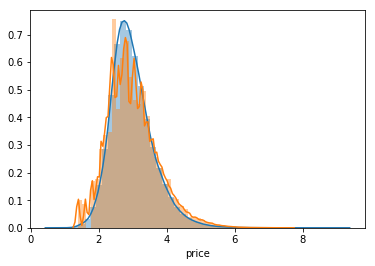

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(oof_preds)
sns.distplot(y)
plt.show()

In [26]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=50, max_depth=3, n_jobs=-1, min_samples_leaf=50)
oof_X = np.hstack((oof_preds1, oof_preds2, oof_preds3))
print(oof_X.shape)
oof2 = cross_val_predict(rfr, oof_X, y , cv=5, verbose=10)
rmse(y, oof2)

(1481658, 3)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.3s remaining:    0.0s


1.988219376342803 4.961022181829234


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.0s finished


0.4244249992307715

In [11]:
#With Nadam lr=0.015, decay=0.005 - mean of 3 models is 0.4185 (0.429, 0.429, 0.428)
#RMSProp lr=0.003, decay=0.005 - mean 0.420 (0.425, 0.426, 0.424)
#RMSProp lr=0.01, decay=0.005 - mean 0.425 (0.434, 0.431, 0.430)
#RMSProp lr=0.004, decay=0.004 - mean 0.421 (0.428, 0.429, 0.427) 
#Adam lr=0.003, decay=0.003 - mean -- (0.4)
#With Nadam lr=0.012, decay=0.01 - mean of 3 models is 0.4175 (0.427, 0.428, 0.429)

#Adam and features lr=0.005, decay=0.001, 0.4137 (0.4207, 0.4204, 0.4213)

In [12]:
nnet1.fit(train_data, np.log1p(train_data.price) )
print("Predicting on test data")
test_preds1 = nnet1.predict(test_data)

nnet2.fit(train_data, np.log1p(train_data.price) )
print("Predicting on test data")
test_preds2 = nnet2.predict(test_data)

nnet3.fit(train_data, np.log1p(train_data.price) )
print("Predicting on test data")
test_preds3 = nnet3.predict(test_data)

test_preds = (1/3)*(test_preds1 + test_preds2 + test_preds3)
print("Write out submission")
submission: pd.DataFrame = test_data[['test_id']]
submission['price'] = np.expm1(test_preds)
submission.price = submission.price.clip(3, 2000)
submission.to_csv("embedding_nn_v2.csv", index=False)

[<tf.Tensor 'reshape_136/Reshape:0' shape=(?, 40) dtype=float32>, <tf.Tensor 'reshape_137/Reshape:0' shape=(?, 30) dtype=float32>, <tf.Tensor 'reshape_138/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_139/Reshape:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'reshape_140/Reshape:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reshape_141/Reshape:0' shape=(?, 20) dtype=float32>, <tf.Tensor 'reshape_142/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_143/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'reshape_144/Reshape:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'dense_cols_30:0' shape=(?, 21) dtype=float32>]
(1444616, 32) (37042, 32) (1444616,) (37042,)
Train on 1444616 samples, validate on 37042 samples
Epoch 1/5
1444616/1444616 [==============================] - 24s 17us/step - loss: 0.5103 - val_loss: 0.2013
Epoch 2/5
1444616/1444616 [==============================] - 18s 12us/step - loss: 0.1956 - val_loss: 0.1780
Epoch 3/5
1444616/1444616 [==============

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mohsin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
